##### <a id='toc1_1_1_1_1_'></a>[Setting up data and imports](#toc0_)


In [1]:
%load_ext autoreload

The autoreload module is not an IPython extension.


In [2]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [1]:
import numpy as np
from importlib import reload

# Importing my modules
from src.main import (
    geometry_operations,
    optimization_compute_quantification,
    classes_linear_optimization,
)

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


In [9]:
# %store -r line_gdf_reworked
%store -r harvesteable_trees_gdf
%store -r height_gdf
%store -r anchor_trees_gdf
%store -r target_trees_gdf
# %store -r line_gdf_v1
%store -r slope_line
%store -r results_df 
%store -r line_gdf_19_10_2023
#rewrite this if the result of the main optimization changed

line_gdf = line_gdf_19_10_2023.copy()
# hack to extract this from the line_gdf
start_point_dict = dict(
    [(key, value.coords[0]) for key, value in enumerate(line_gdf["line_candidates"])]
)

#### <a id='toc1_1_1_2_'></a>[Optimization Setup](#toc0_)


In [11]:
bhd_series = harvesteable_trees_gdf["BHD"]
height_series = harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)

# Prepare the gdfs
uphill_yarding = True
line_gdf["line_cost"] = optimization_compute_quantification.compute_line_costs(
    line_gdf, uphill_yarding, large_yarder=True
)
harvesteable_trees_gdf[
    "cubic_volume"
] = optimization_compute_quantification.compute_tree_volume(bhd_series, height_series)

In [8]:
line_gdf = line_gdf.iloc[0:10]
harvesteable_trees_gdf = harvesteable_trees_gdf.iloc[0:100]

#### Clustering Trees for Sortiment


In [12]:
from sklearn.cluster import KMeans

n_clusters = len(harvesteable_trees_gdf) // 20
k_means = KMeans(n_clusters=n_clusters)
y = k_means.fit_predict(
    X=[*zip(harvesteable_trees_gdf["x"], harvesteable_trees_gdf["y"])]
)

In [13]:
import plotly.express as px

fig = px.scatter()
fig.add_scatter(
    x=harvesteable_trees_gdf["x"],
    y=harvesteable_trees_gdf["y"],
    mode="markers",
    marker=dict(color=y),
)

fig.show()

Der A-Wert ist prinzipiell nicht auf eine Baumart beschränkt, bislang wurde er jedoch von uns nur in Fichtenbeständen angewandt. Er ist zum einen vom H/D-Wert (Höhe zu Durchmesser) des Z-Baumes und zum anderen vom Durchmesser und dem Abstand des jeweiligen Nachbarbaumes abhängig. Bei der Entwicklung des A-Wertes ging Johann von folgenden, jedem Forstmann bekannten Überlegungen aus:

    Der Standraumbedarf eines Z-Stammes ist umso größer, je höher er ist. Ein Nachbarbaum wird zum Konkurrenten (K), indem er in den Standraum des Z-Stammes (Z) eindringt. Ist die Höhe des Konkurrenten gleich wie die Höhe (H) des Z-Baumes, d.h. von gleicher sozialer Stel-lung, so steigt der Konkurrenzdruck mit zunehmender Baumhöhe und abnehmen-der Entfernung (E) zwischen den beiden: H/E
    Ein niedriger bzw. (sozial) schwächerer Baum wird auf den Z-Stamm vergleichsweise einen geringeren Konkurrenzdruck ausüben als ein stärkerer. Dieser Sachverhalt lässt sich auch als Verhältnis der Durchmesser von Konkurrent (d) zu Z-Stamm (D) darstellen: d/D

Beide Überlegungen zusammengefasst ergeben die Formel für den A-Wert eines Nachbarbaumes des Z-Stammes:
A=H/E \* d/D

Bei der Freistellung nach A-Wert wird ein Konkurrent immer dann entnommen, wenn seine Entfernung zum Z-Baum eine bestimmte Grenzdistanz (GD) – bei festgelegtem A-Wert - unterschreitet:
GD < H/A\*d/D

In der Abbildung 1 ist der Zusammenhang zwischen H/D-Wert des Z-Baumes, BHD des Konkurrenten und Grenzdistanz dargestellt. Beispielsweise beträgt für einen Z-Stamm mit H/D-Wert 80 und einem festgelegten A-Wert von 4 bzw. 6 die Grenz-distanz eines Konkurrenten mit 30 cm BHD 6 m bzw. 4 m; bei einem H/D-Wert von 100 betragen die Grenzdistanzen 7,5 m bzw. 5 m.


In [18]:
harvesteable_trees_gdf["h"] = (
    harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)
)

In [19]:
harvesteable_trees_gdf["H/D_value"] = (
    harvesteable_trees_gdf["h"] / harvesteable_trees_gdf["BHD"]
)

indexes_to_keep = []
A_value = 5

# doing this too many times
for cluster in range(n_clusters):
    # select trees
    index = np.where(y == cluster)
    sub_df = harvesteable_trees_gdf.iloc[index]

    # determine index of largest tree
    z_tree_index = sub_df["BHD"].idxmax()
    z_tree = sub_df.loc[z_tree_index]
    z_tree_bhd = z_tree["BHD"]
    z_tree_h = z_tree["h"]

    # compute the distance of all trees to the largest tree
    sub_df["distance_to_z_tree"] = sub_df.distance(sub_df.loc[z_tree_index].geometry)

    # drop the largest tree from the dataframe so we dont fell it
    sub_df.drop(z_tree_index, inplace=True)

    # # A=H/E * d/D
    # sub_df["A_value"] = (z_tree_h / sub_df["distance_to_z_tree"]) * (
    #     sub_df["BHD"] / z_tree_bhd
    # )

    # select those trees which are too close to the z tree with GD < H/A*d/D
    # negate the condition, since those are the trees we keep. The trees in the list will be felled
    sub_df = sub_df[
        ~(
            sub_df["distance_to_z_tree"]
            < (z_tree_h / A_value) * (sub_df["BHD"] / z_tree_bhd)
        )
    ]

    # add the indexes to fell to the list
    indexes_to_keep.extend(sub_df.index)

harvesteable_trees_gdf_sortiment = harvesteable_trees_gdf.loc[indexes_to_keep]

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_477618/3571965119.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [20]:
print(
    "went from ",
    len(harvesteable_trees_gdf),
    " to ",
    len(harvesteable_trees_gdf_sortiment),
    " trees",
)

went from  516  to  464  trees


#### <a id='toc1_1_1_3_'></a>[Single-Objective](#toc0_)


In [100]:
reload(optimization_compute_quantification)
reload(classes_linear_optimization)
# Lists to store the results
optimization_result_list = []
lscp_model_list = []

for i in range(0, 3):
    print(f"Starting with objective {i}")
    # set up the model with firs the monetary objective (0), then sideways slope (1) and steep segments (2) as single objective
    lscp_optimization = classes_linear_optimization.optimization_object_spopt(
        "Single Objective",
        line_gdf,
        harvesteable_trees_gdf,
        height_gdf,
        objective_to_select=i,
    )
    lscp_optimization.add_generic_vars_and_constraints()
    lscp_optimization.add_single_objective_function()
    # and solve it
    lscp_optimization.solve()
    lscp_model_list.append(lscp_optimization)

Starting with objective 0
Starting with objective 1
Starting with objective 2


In [101]:
optimization_result_list = []

In [102]:
reload(classes_linear_optimization)
for count, optimization_object in enumerate(lscp_model_list):
    optimization_result_list.append(
        classes_linear_optimization.spopt_result(
            optimization_object,
            line_gdf,
            optimization_object.name + str(count),
        )
    )

#### <a id='toc1_1_1_4_'></a>[NSGA 2](#toc0_)


In [103]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from src.main import classes_mo_optimization

reload(classes_mo_optimization)

cost_matrix = lscp_model_list[0].distance_tree_line
nsga_problem = classes_mo_optimization.optimization_object_pymoo(
    cost_matrix,
    lscp_model_list[0].productivity_cost,
    lscp_model_list[0].facility_cost,
    lscp_model_list[0].ecological_penalty_lateral_distances,
    lscp_model_list[0].ergonomic_penalty_lateral_distances,
)
termination = get_termination("n_gen", 10)


client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    pop_size=10,
    sampling=classes_mo_optimization.CustomSampling(),  # initally zero matrix, nothing assigned
    mutation=classes_mo_optimization.MyMutation(),
    repair=classes_mo_optimization.MyRepair(),
)

# %prun minimize(problem,algorithm,termination,verbose=True,return_least_infeasible=True,seed=0)
res = minimize(
    nsga_problem,
    algorithm,
    termination,
    verbose=True,
    return_least_infeasible=True,
    seed=0,
)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       11 |     10 |  0.000000E+00 |  0.000000E+00 |  1.852657E+03 |         ideal


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/main/classes_mo_optimization.py:369: RuntimeWarning:

overflow encountered in exp



     3 |       21 |     10 |  0.000000E+00 |  0.000000E+00 |  1.112738E+04 |         ideal
     4 |       31 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |       41 |     10 |  0.000000E+00 |  0.000000E+00 |  3.472548E+03 |         ideal
     6 |       51 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |       61 |     10 |  0.000000E+00 |  0.000000E+00 |  8.187016E+02 |         ideal
     8 |       71 |     10 |  0.000000E+00 |  0.000000E+00 |  1.091464E+02 |         ideal
     9 |       81 |     10 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
    10 |       91 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


In [104]:
reload(classes_mo_optimization)
len_x = len(res.X)
optimization_result_list = []
samples = 10
for i in np.linspace(0, len_x - 1, samples).astype(int):
    optimization_result_list.append(
        classes_mo_optimization.pymoo_result(
            res.problem,
            res.X[i],
            line_gdf,
            client_range,
            facility_range,
            "NSGA2 " + str(i),
        )
    )

Profit baseline is 56144.89824448312


<AxesSubplot:>

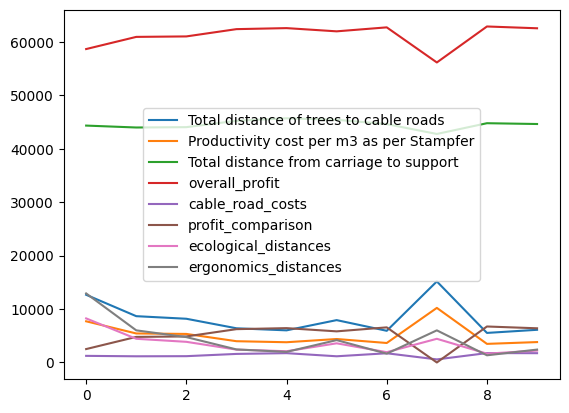

In [105]:
reload(classes_linear_optimization)

tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
(
    distance_tree_line,
    distance_carriage_support,
) = geometry_operations.compute_distances_facilities_clients(
    harvesteable_trees_gdf, line_gdf
)
sample_model = lscp_model_list[0]

results_df = classes_linear_optimization.model_results_comparison(
    optimization_result_list,
    line_gdf,
    sample_model.distance_tree_line,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
)

results_df.plot()

### AUGMECON MOO


#### Creating the reference table for AUGMECON approach


In [106]:
# determine the ranges of the objectives and divide them in 10 equal parts
ecological_true_max = results_df["ecological_distances"].max()
ecological_true_min = results_df["ecological_distances"].min()
# ecological_true_min = 120
ergonomics_true_max = results_df["ergonomics_distances"].max()
ergonomics_true_min = results_df["ergonomics_distances"].min()
# ergonomics_true_min = 63

# first determine the ranges of the objectives
max_overall_profit = results_df["overall_profit"].max()
min_overall_profit = results_df["overall_profit"].min()

grid_points = 5
# create a grid of points to evaluate the objective functions
profit_range = np.linspace(min_overall_profit, max_overall_profit, grid_points)

ecological_range, ecological_step = np.linspace(
    ecological_true_max,
    ecological_true_min,
    grid_points,
    retstep=True,
)

ergonomics_range, ergonomics_step = np.linspace(
    ergonomics_true_max, ergonomics_true_min, grid_points, retstep=True
)

In [108]:
from itertools import islice

reload(classes_linear_optimization)
# line_gdf = line_gdf.iloc[0:5]
# harvesteable_trees_gdf = harvesteable_trees_gdf.iloc[0:20]
pareto_optimal_objective_values = [0]
pareto_optimal_objects = []


def augmecon():
    initial_model = classes_linear_optimization.optimization_object_spopt(
        "Single Objective",
        line_gdf,
        harvesteable_trees_gdf,
        height_gdf,
        objective_to_select=0,
    )

    initial_model.add_generic_vars_and_constraints()
    # add the main monetary objective
    initial_model.add_single_objective_function()
    initial_model.solve()

    # set up the ranges at iteration objects so we can skip steps in the loop
    i_range = iter(ecological_range)

    for i in i_range:
        print("i should be :", i)
        initial_model.add_epsilon_constraint(target_value=i, objective_to_select=1)

        try:
            initial_model.solve()
        except:
            print("couldnt solve with i ", i)
            break

        (
            cost_objective,
            ecological_objective,
            ergonomics_objective,
        ) = initial_model.get_objective_values()
        # determine the slack variable of the ecological constraint - this is the value of the objective function minus the expected value as per the ecological range
        i_slack = ecological_objective - i
        print("i is :", ecological_objective)

        j_range = iter(ergonomics_range)
        # loop through the inner objective
        for j in j_range:
            print("          j should be:", j)
            initial_model.add_epsilon_constraint(target_value=j, objective_to_select=2)

            try:
                initial_model.solve()
            except:
                print("couldnt solve with j ", j)
                break

            # determine the slack variable of the ergonomics constraint - this is the value of the objective function minus the expected value as per the ergonomics range
            j_slack = ergonomics_objective - j
            print("          j is : ", ergonomics_objective)
            print("          cost is :", cost_objective)

            # since we could solve this problem, this is a pareto-optimal solution - get the objective value and store it
            overall_objective = initial_model.get_total_epsilon_objective_value(
                (ecological_true_max - ecological_true_min),
                (ergonomics_true_max - ergonomics_true_min),
            )

            ecological_index = np.where(ecological_range == i)[0][0]
            ergonomics_index = np.where(ergonomics_range == j)[0][0]
            result = classes_linear_optimization.spopt_result(
                initial_model,
                line_gdf,
                "Augmecon" + str(ecological_index) + str(ergonomics_index),
            )

            # pareto_optimal_objective_values.append(overall_objective)
            pareto_optimal_objects.append(result)

            (
                cost_objective,
                ecological_objective,
                ergonomics_objective,
            ) = initial_model.get_objective_values()

            # set the new objective
            initial_model.add_epsilon_objective(
                i_slack, j_slack, ecological_range, ergonomics_range
            )

            surface_plot_data_x.append(cost_objective)
            surface_plot_data_y.append(ecological_objective)
            surface_plot_data_z.append(ergonomics_objective)

            if j_slack > 0:
                print("couldnt improve objective?")
                break  # skipping the rest of the ergonomics range since we cant improve the objective anymore
            else:
                # the expected value as per the ergonomics range. If the slack variable is greater than what we would constrain for the next step, we skip those iterations
                j_bypass = int(abs(np.floor(j_slack / ergonomics_step)))
                if j_bypass > 0:
                    # for iterator j, skip j_bypass steps
                    print("         skipping j_bypass:", j_bypass)
                    next(islice(j_range, j_bypass, j_bypass), None)


surface_plot_data_x = []
surface_plot_data_y = []
surface_plot_data_z = []
augmecon()

i should be : 8248.420032851947
i is : 1231.267346761515
          j should be: 12923.290848347551
          j is :  780.3848633390048
          cost is : 4937.3942469894955


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 4
i should be : 6598.443072777666
i is : 1231.267346761515
          j should be: 12923.290848347551
          j is :  780.3848633390048
          cost is : 4937.3942469894955


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 4
i should be : 4948.466112703385
i is : 1231.267346761515
          j should be: 12923.290848347551
          j is :  780.3848633390048
          cost is : 4937.3942469894955


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 4
i should be : 3298.489152629105
i is : 1231.267346761515
          j should be: 12923.290848347551
          j is :  780.3848633390048
          cost is : 4937.3942469894955


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 4
i should be : 1648.5121925548237
i is : 1231.267346761515
          j should be: 12923.290848347551
          j is :  780.3848633390048
          cost is : 4937.3942469894955
         skipping j_bypass: 4


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



In [109]:
optimization_result_list = optimization_result_list + pareto_optimal_objects

#### Comparison of Optimization Results


Profit baseline is 56144.89824448312


,Productivity cost per m3 as per Stampfer,overall_profit,profit_comparison,cable_road_costs,Total distance from carriage to support,Total distance of trees to cable roads,ecological_distances,ergonomics_distances
name,,,,,,,,
NSGA2 0,7706,58653,2508,1238,44332,12670,8248,12923
NSGA2 1,5429,60930,4785,1157,43973,8665,4432,6011
NSGA2 2,5341,61018,4873,1180,44038,8181,3864,4748
NSGA2 3,3979,62380,6235,1601,45224,6398,2406,2440
NSGA2 4,3787,62572,6427,1743,45699,6012,2104,1982
NSGA2 5,4391,61968,5823,1160,45421,7927,3585,4186
NSGA2 6,3646,62714,6569,1723,44607,5928,1927,1651
NSGA2 7,10215,56144,0,575,42763,15166,4432,6011
NSGA2 8,3481,62879,6734,1756,44776,5531,1648,1343


<AxesSubplot:xlabel='name'>

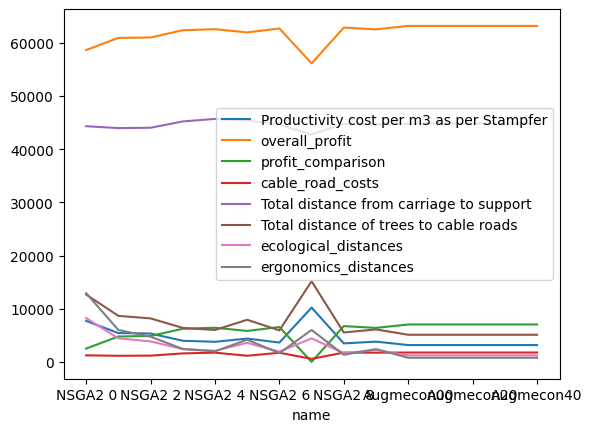

In [110]:
reload(classes_linear_optimization)

tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
(
    distance_tree_line,
    distance_carriage_support,
) = geometry_operations.compute_distances_facilities_clients(
    harvesteable_trees_gdf, line_gdf
)
sample_model = lscp_model_list[0]

results_df = classes_linear_optimization.model_results_comparison(
    optimization_result_list,
    line_gdf,
    sample_model.distance_tree_line,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
)

results_df[results_df.columns[:6]] = results_df[results_df.columns[:6]].astype(int)
results_df[results_df.columns[7:]] = results_df[results_df.columns[7:]].astype(int)
results_df = results_df.reindex(
    columns=[
        "name",
        "Productivity cost per m3 as per Stampfer",
        "overall_profit",
        "profit_comparison",
        "cable_road_costs",
        "Total distance from carriage to support",
        "Total distance of trees to cable roads",
        "ecological_distances",
        "ergonomics_distances",
    ]
)
results_df.set_index("name", inplace=True)
display(results_df)
results_df.plot()

In [75]:
pd.options.plotting.backend = "matplotlib"

array([[<AxesSubplot:title={'center':'Overall profit'}, xlabel='name'>,
        <AxesSubplot:title={'center':'Sideways slope deviations'}, xlabel='name'>,
        <AxesSubplot:title={'center':'Bad ergonomics distance'}, xlabel='name'>]],
      dtype=object)

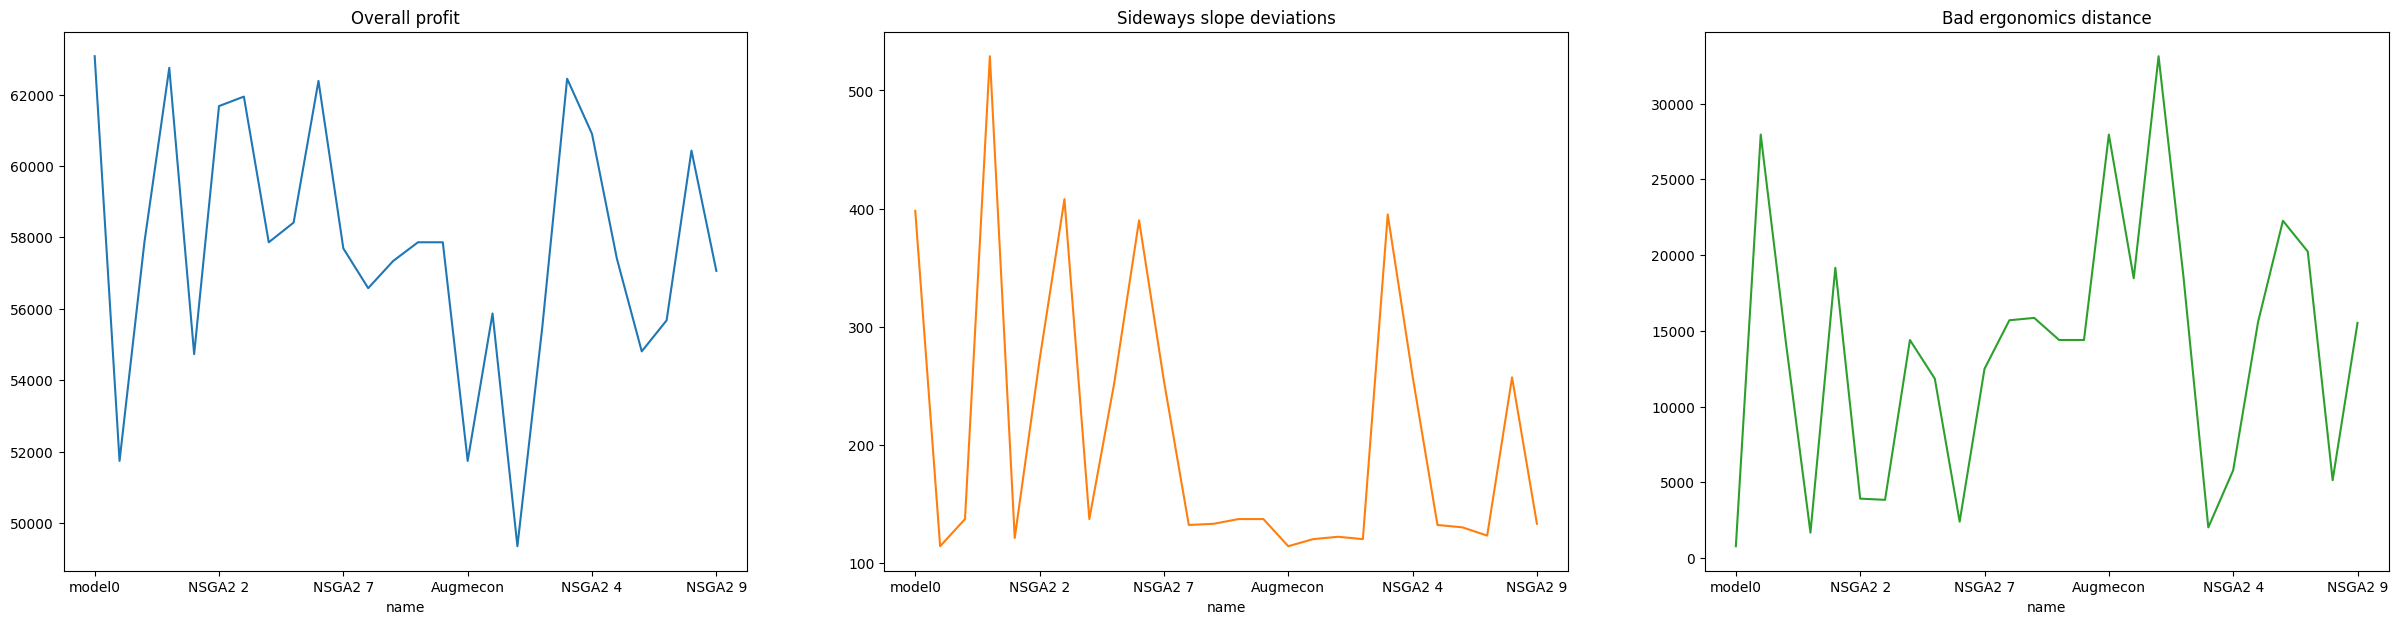

In [76]:
results_df[
    ["overall_profit", "sideways_slope_deviations", "bad_ergonomics_distance"]
].plot(
    subplots=True,
    layout=(1, 3),
    figsize=(30, 7),
    legend=False,
    title=["Overall profit", "Sideways slope deviations", "Bad ergonomics distance"],
)

In [88]:
from src.main import plotting_2d

reload(plotting_2d)
for result in optimization_result_list:
    fig = plotting_2d.plot_optimization_layout(result, line_gdf, harvesteable_trees_gdf)
    fig.update_layout(showlegend=False)
    fig.show("notebook_connected")

In [100]:
reload(plotting_2d)
import plotly.graph_objects as go
from ipywidgets import VBox

f = go.FigureWidget(
    go.Scatter3d(
        x=results_df["sideways_slope_deviations"],
        y=results_df["bad_ergonomics_distance"],
        z=results_df["overall_profit"],
    )
)

f.update_layout(
    width=1200,
    height=800,
    title="Pareto Frontier",
    xaxis_title="Sideways slope deviations",
    yaxis_title="bad_ergonomics_distance",
    scene_zaxis_title="Overall profit",
)

t = go.FigureWidget([])


def selection_fn(trace, points, selector):
    # get index of this point in the trace
    index = points.point_inds[0]

    # update the layout plot to show this result
    t.data = []
    #
    t.add_traces(
        list(
            plotting_2d.plot_optimization_layout(
                optimization_result_list[index], line_gdf, harvesteable_trees_gdf
            ).data
        )
    )

    t.update_layout(title=optimization_result_list[index].name)


t.update_layout(width=1200, height=800)
f.data[0].on_click(selection_fn)
VBox((f, t))

    'data': [{'type': 'scatter3d',
              'uid': '989a5aef-7499-4a76-9326…

#### Interactive CR Selection


In [77]:
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np
from ipywidgets import VBox

from random import random

# create a trace for the trees
xs, ys = zip(*[(row.xy[0][0], row.xy[1][0]) for row in harvesteable_trees_gdf.geometry])
trees = go.Scatter(
    x=xs,
    y=ys,
    mode="markers",
    marker=dict(color="green"),
    name="trees",
)

# Create traces for each line
individual_lines = [
    go.Scatter(
        x=np.asarray(row.geometry.xy[0]) + random(),
        y=np.asarray(row.geometry.xy[1]) + random(),
        mode="lines",
        line=dict(color="lightgrey"),
        name=str(id),
    )
    for id, row in line_gdf.iterrows()
]

# create a figure from all individual scatter lines
f = go.FigureWidget([*individual_lines, trees])
f.update_layout(
    width=2000,
    height=1800,
)


# create the onclick function to select new CRs
def selection_fn(trace, points, selector):
    # since the handler is activated for all lines, test if this one has coordinates, ie. is the clicked line
    if points.xs:
        if trace.line.color == "black":
            f.update_traces(line=dict(color="lightgrey"), selector={"name": trace.name})
        elif trace.line.color == "lightgrey":
            # update this trace to turn black
            f.update_traces(line=dict(color="black"), selector={"name": trace.name})

        # get all active traces
        active_traces = f.select_traces(selector={"line.color": "black"})
        active_traces_names = [int(trace.name) for trace in active_traces]

        # set the dataframe rows to show only these CRs
        t.data[0].cells.values = [df[df.index.isin(active_traces_names)]]
        # and update the dataframe showing the computed costs
        c.data[0].cells.values, test = update_layout_cost_df(active_traces_names)


# add the onclick function to all traces
for trace in f.data:
    trace.on_click(selection_fn)

# create a dataframe and push it to a figurewidget to display details about our selected lines
df = line_gdf[["line_cost", "line_length"]]
t = go.FigureWidget([go.Table(header=dict(values=df.columns), cells=dict(values=[df]))])

cost_gdf = pd.DataFrame(
    columns=["Tree_to_line_distance", "Productivity_cost", "Line_cost", "Profit"]
)
c = go.FigureWidget(
    [go.Table(header=dict(values=cost_gdf.columns), cells=dict(values=[cost_gdf]))]
)


def update_layout_cost_df(indices):
    rot_line_gdf = line_gdf[line_gdf.index.isin(indices)]

    # Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
    (
        distance_tree_line,
        distance_carriage_support,
    ) = geometry_operations.compute_distances_facilities_clients(
        harvesteable_trees_gdf, rot_line_gdf
    )

    # assign all trees to their closest line
    try:
        tree_to_line_assignment = np.argmin(distance_tree_line, axis=1)

        # compute the distance of each tree to its assigned line
        distance_trees_to_lines = sum(
            distance_tree_line[
                range(len(tree_to_line_assignment)), tree_to_line_assignment
            ]
        )
    except:
        tree_to_line_assignment = [1 for i in range(len(distance_tree_line))]
        distance_trees_to_lines = sum(distance_tree_line)

    # compute the productivity cost
    productivity_cost_overall = np.sum(
        lscp_model_list[0].productivity_cost[
            range(len(tree_to_line_assignment)), tree_to_line_assignment
        ]
    )

    print(indices)
    line_cost = sum(rot_line_gdf["line_cost"])
    return [
        distance_trees_to_lines,
        productivity_cost_overall,
        line_cost,
        63025 - productivity_cost_overall,
        tree_to_line_assignment,
    ]


# Put everything together in a VBox
VBox((f, t, c))

    'data': [{'line': {'color': 'lightgrey'},
              'mode': 'lines',
   …

In [119]:
reload(plotting_2d)

## Computing cost of Christophs layout

selected_lines = [32, 59, 71]
a, b, c, d, e = update_layout_cost_df(selected_lines)

fac2cli = [[] for i in range(len(line_gdf))]
for index, val in enumerate(e):
    fac2cli[selected_lines[val]].append(index)

expert_df_1 = plotting_2d.expert_results_extraction(
    fac2cli,
    line_gdf,
    sample_model.aij,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
    sample_model.sideways_slope_deviations_per_cable_road,
    sample_model.ergonomic_penalty_lateral_distances,
    "expert_layout",
)

expert_df_1

[32, 59, 71]
Profit baseline is 62091.53735670836


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,bad_ergonomics_distance
0,5285.048891,4268.784147,45026.320343,62091.537357,1740.761392,0.0,expert_layout,396.377049,66704.044495


In [117]:
reload(plotting_2d)

## Computing cost of Christophs layout

selected_lines = [30, 37]
a, b, c, d, e = update_layout_cost_df(selected_lines)

fac2cli = [[] for i in range(len(line_gdf))]
for index, val in enumerate(e):
    fac2cli[selected_lines[val]].append(index)

expert_df_2 = plotting_2d.expert_results_extraction(
    fac2cli,
    line_gdf,
    sample_model.aij,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
    sample_model.sideways_slope_deviations_per_cable_road,
    sample_model.ergonomic_penalty_lateral_distances,
    "expert_layout",
)

expert_df_2

[30, 37]
Profit baseline is 61938.02227946889


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,bad_ergonomics_distance
0,7927.307317,4422.299225,45421.926804,61938.022279,1160.394259,0.0,expert_layout,264.050473,38082.1076


In [120]:
expert_df = pd.concat([expert_df_1, expert_df_2])
expert_df

,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,bad_ergonomics_distance
0,5285.048891,4268.784147,45026.320343,62091.537357,1740.761392,0.0,expert_layout,396.377049,66704.044495
0,7927.307317,4422.299225,45421.926804,61938.022279,1160.394259,0.0,expert_layout,264.050473,38082.107600
